# 环境安装

In [ ]:
# pip
!pip install -r requirements.txt -i https://mirrors.aliyun.com/pypi/simple/
# conda 用conda建议使用下面
#!conda env create -f environment.yml
#!conda activate image

# 导入相关库

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.util as util
from skimage import img_as_float
# 结构相似度
from skimage.metrics import structural_similarity as ssim
# 均方和
from skimage.metrics import mean_squared_error as MSE
# 信噪比
from skimage.metrics import peak_signal_noise_ratio as psnr

读取需要处理的图片

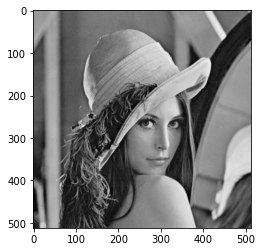

In [2]:
image = cv2.imread("./image.jpg")
image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
image = img_as_float(image)
plt.imshow(image,cmap="gray")

添加椒盐噪声

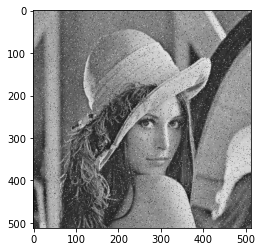

In [3]:
# 椒盐噪声
salt_noise = util.random_noise(image,mode='s&p')
plt.imshow(salt_noise,cmap='gray')

# 均值平滑和

In [4]:
def mean_filter(image,kernel_size):
    '''
    '''
    # 原始图像长宽
    row,col = image.shape
    # 需要填充的大小 
    pad = kernel_size // 2
    # 零填充
    pad_image = np.pad(image,pad_width=(pad,pad),mode = 'constant')
    # 输出图像
    out = np.zeros_like(image,dtype=np.double)
    for x in range(pad,row+pad):
        for y in range(pad,col+pad):
            # 均值平滑的窗口
            windows = pad_image[x-pad:x+pad+1,y-pad:y+pad+1]
            # 由于均值平滑的卷积核都为1，直接求平均
            out[x-pad][y-pad] = np.average(windows)
    return out

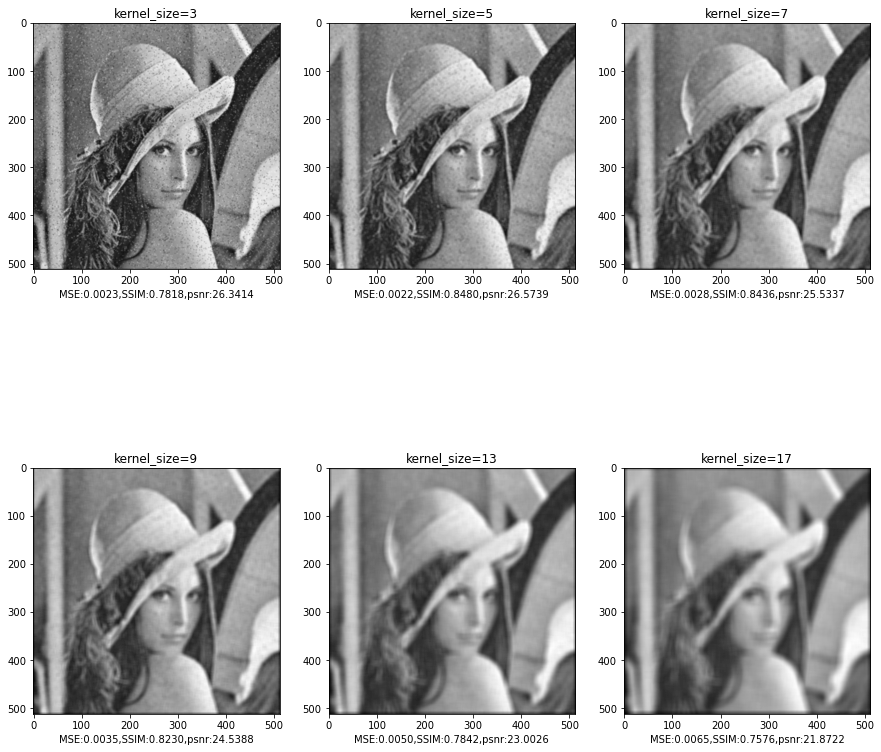

In [5]:
# 窗口大小
kernel_size = [3,5,7,9,13,17]
# 列表长度
list_len = len(kernel_size)
# 保存的句柄
plt.figure(figsize=(15,15))
for index in range(list_len):
    # 图像位置
    plt.subplot(2,3,index+1)
    # 均值平滑
    blur = mean_filter(salt_noise,kernel_size[index])
    # 比较
    _mse = MSE(image,blur)
    _ssim = ssim(image,blur)
    _psnr = psnr(image,blur)
    # 展示
    plt.imshow(blur,cmap='gray')
    ax = plt.gca()
    ax.set_xlabel('MSE:{:.4f},SSIM:{:.4f},psnr:{:.4f}'.format(_mse,_ssim,_psnr))
    plt.title("kernel_size=%d"%(kernel_size[index]))
# 保存
plt.savefig("./mean_blur")


对比不同的内核大小，可以看到随着均值平滑和的内核大时，图片也将相对模糊，较小的内核大小时保存的细节较好

# k邻点平均

In [6]:
def k_nearest_average_filter(image,kernel_size,k_num):
    '''
    '''
    rows,cols = image.shape
    pad = kernel_size//2
    pad_image = np.pad(image,(pad,pad),mode='constant')
    out = np.zeros((rows,cols),dtype=np.double)

    for x in range(pad,rows+pad):
        for y in range(pad,cols+pad):
            windows = pad_image[x-pad:x+pad+1,y-pad:y+pad+1]
            flatten = (windows-pad_image[x][y]).reshape(kernel_size**2)
            sort = np.argsort(np.abs(flatten))
            out[x-pad][y-pad] = np.average(flatten[sort[1:k_num+1]]) + pad_image[x][y]
    
    return out

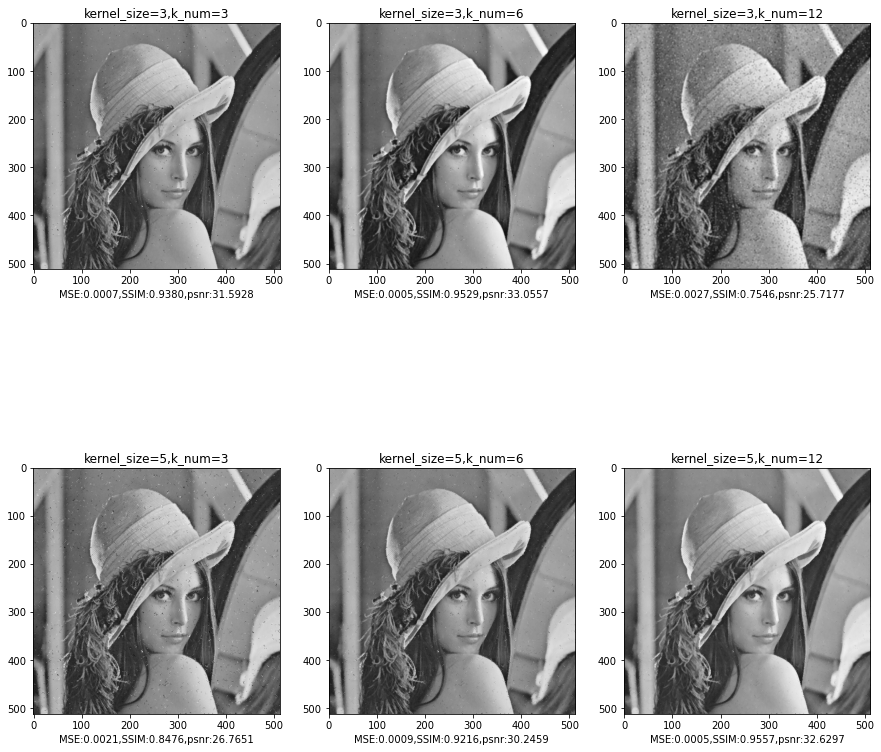

In [7]:
config = [(3,3),(3,6),(3,12),(5,3),(5,6),(5,12)]
# 列表长度
list_len = len(kernel_size)
# 保存的句柄
plt.figure(figsize=(15,15))
for index in range(list_len):
    # 图像位置
    plt.subplot(2,3,index+1)
    # k邻近平均
    blur = k_nearest_average_filter(salt_noise,config[index][0],config[index][1])
    # 比较
    _mse = MSE(image,blur)
    _ssim = ssim(image,blur)
    _psnr = psnr(image,blur)
    # 展示
    plt.imshow(blur,cmap='gray')
    ax = plt.gca()
    ax.set_xlabel('MSE:{:.4f},SSIM:{:.4f},psnr:{:.4f}'.format(_mse,_ssim,_psnr))
    plt.title("kernel_size=%d,k_num=%d"%(config[index][0],config[index][1]))
# 保存
plt.savefig("./k_blur")

较小的k值细节保存较好，噪声方差降低较少。较大k值的噪声处理效果较好，但是图像更模糊

# 比较
比较可以发现，相对来说k邻点平均效果更好，平滑后的信噪比更高。与原图片的差异更小。细节保存更多。

# 空间周期性噪声去除


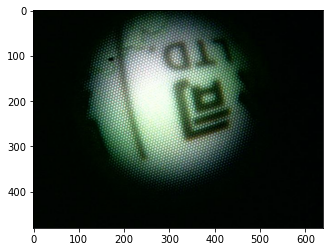

In [8]:
# 原始图片
image = cv2.imread('./noise.jpg')
plt.imshow(image)

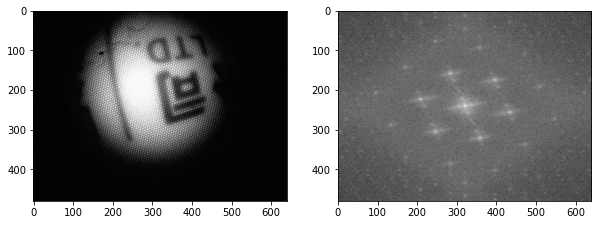

In [9]:
# 转换灰度图
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
# fft
F = np.fft.fft2(gray)
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(gray,cmap='gray')
plt.subplot(122)
fft_shift = np.fft.fftshift(F)
# 取log方便观察
plt.imshow(np.log(np.abs(fft_shift)+1),cmap='gray')

由于重复为蜂窝状，有六个边。可以看到其中围绕中心的6个脉冲点，那个就是噪声

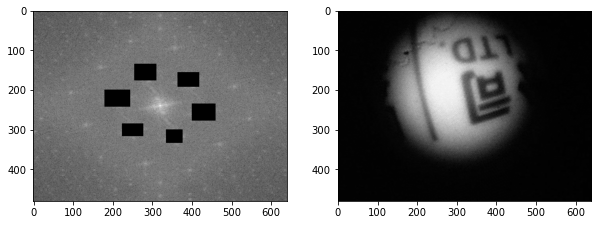

In [10]:
fft_shift_temp = np.log(np.abs(fft_shift)+1)
# 掩码
mask = np.ones_like(fft_shift_temp)
# 6个区域选择
zooms = [(180, 200, 245, 243), (224, 285, 278, 317), (335, 300, 377, 334),
         (400, 235, 460, 278), (364, 156, 419, 193), (255, 135, 311, 177)]

# 将区域内赋0
for zoom in zooms:
    mask[zoom[1]:zoom[3],zoom[0]:zoom[2]] = 0

plt.figure(figsize=(10,10))
plt.subplot(121)
# 观察掩码的区域
fft_shift_temp = np.multiply(fft_shift_temp,mask)
plt.imshow(fft_shift_temp,cmap='gray')
plt.subplot(122)
# 尝试在灰度图上滤波
raw = np.fft.ifft2(np.fft.ifftshift(np.multiply(fft_shift,mask)))
raw = np.abs(raw)
plt.imshow(raw,cmap='gray')


可以看到滤波器在灰度图上消除了蜂窝状周期噪声

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


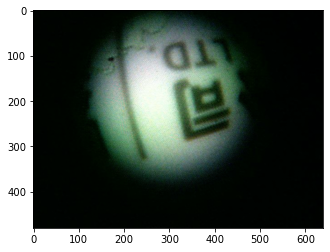

In [11]:
# rgb通道分离
b = image[:,:,0]
g = image[:,:,1]
r = image[:,:,2]

in_channel = [b,g,r]
out_channel = []
# 对三色通道进行滤波
for channel in in_channel:
    fft = np.fft.fftshift(np.fft.fft2(channel))
    fft = np.multiply(fft,mask)
    out = np.fft.ifft2(np.fft.ifftshift(fft))
    out_channel.append(np.abs(out).astype(np.uint))

b,g,r = out_channel
# 合并
BGR = np.dstack((b,g,r))
# 观察结果
plt.imshow(BGR)
plt.savefig('./result.png')


可以看到滤波后的图像消除了蜂窝状噪声